In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn
import sklearn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split

# from dataset import *
# from model import *
# from train import *
# from utils import *

# Wireline input

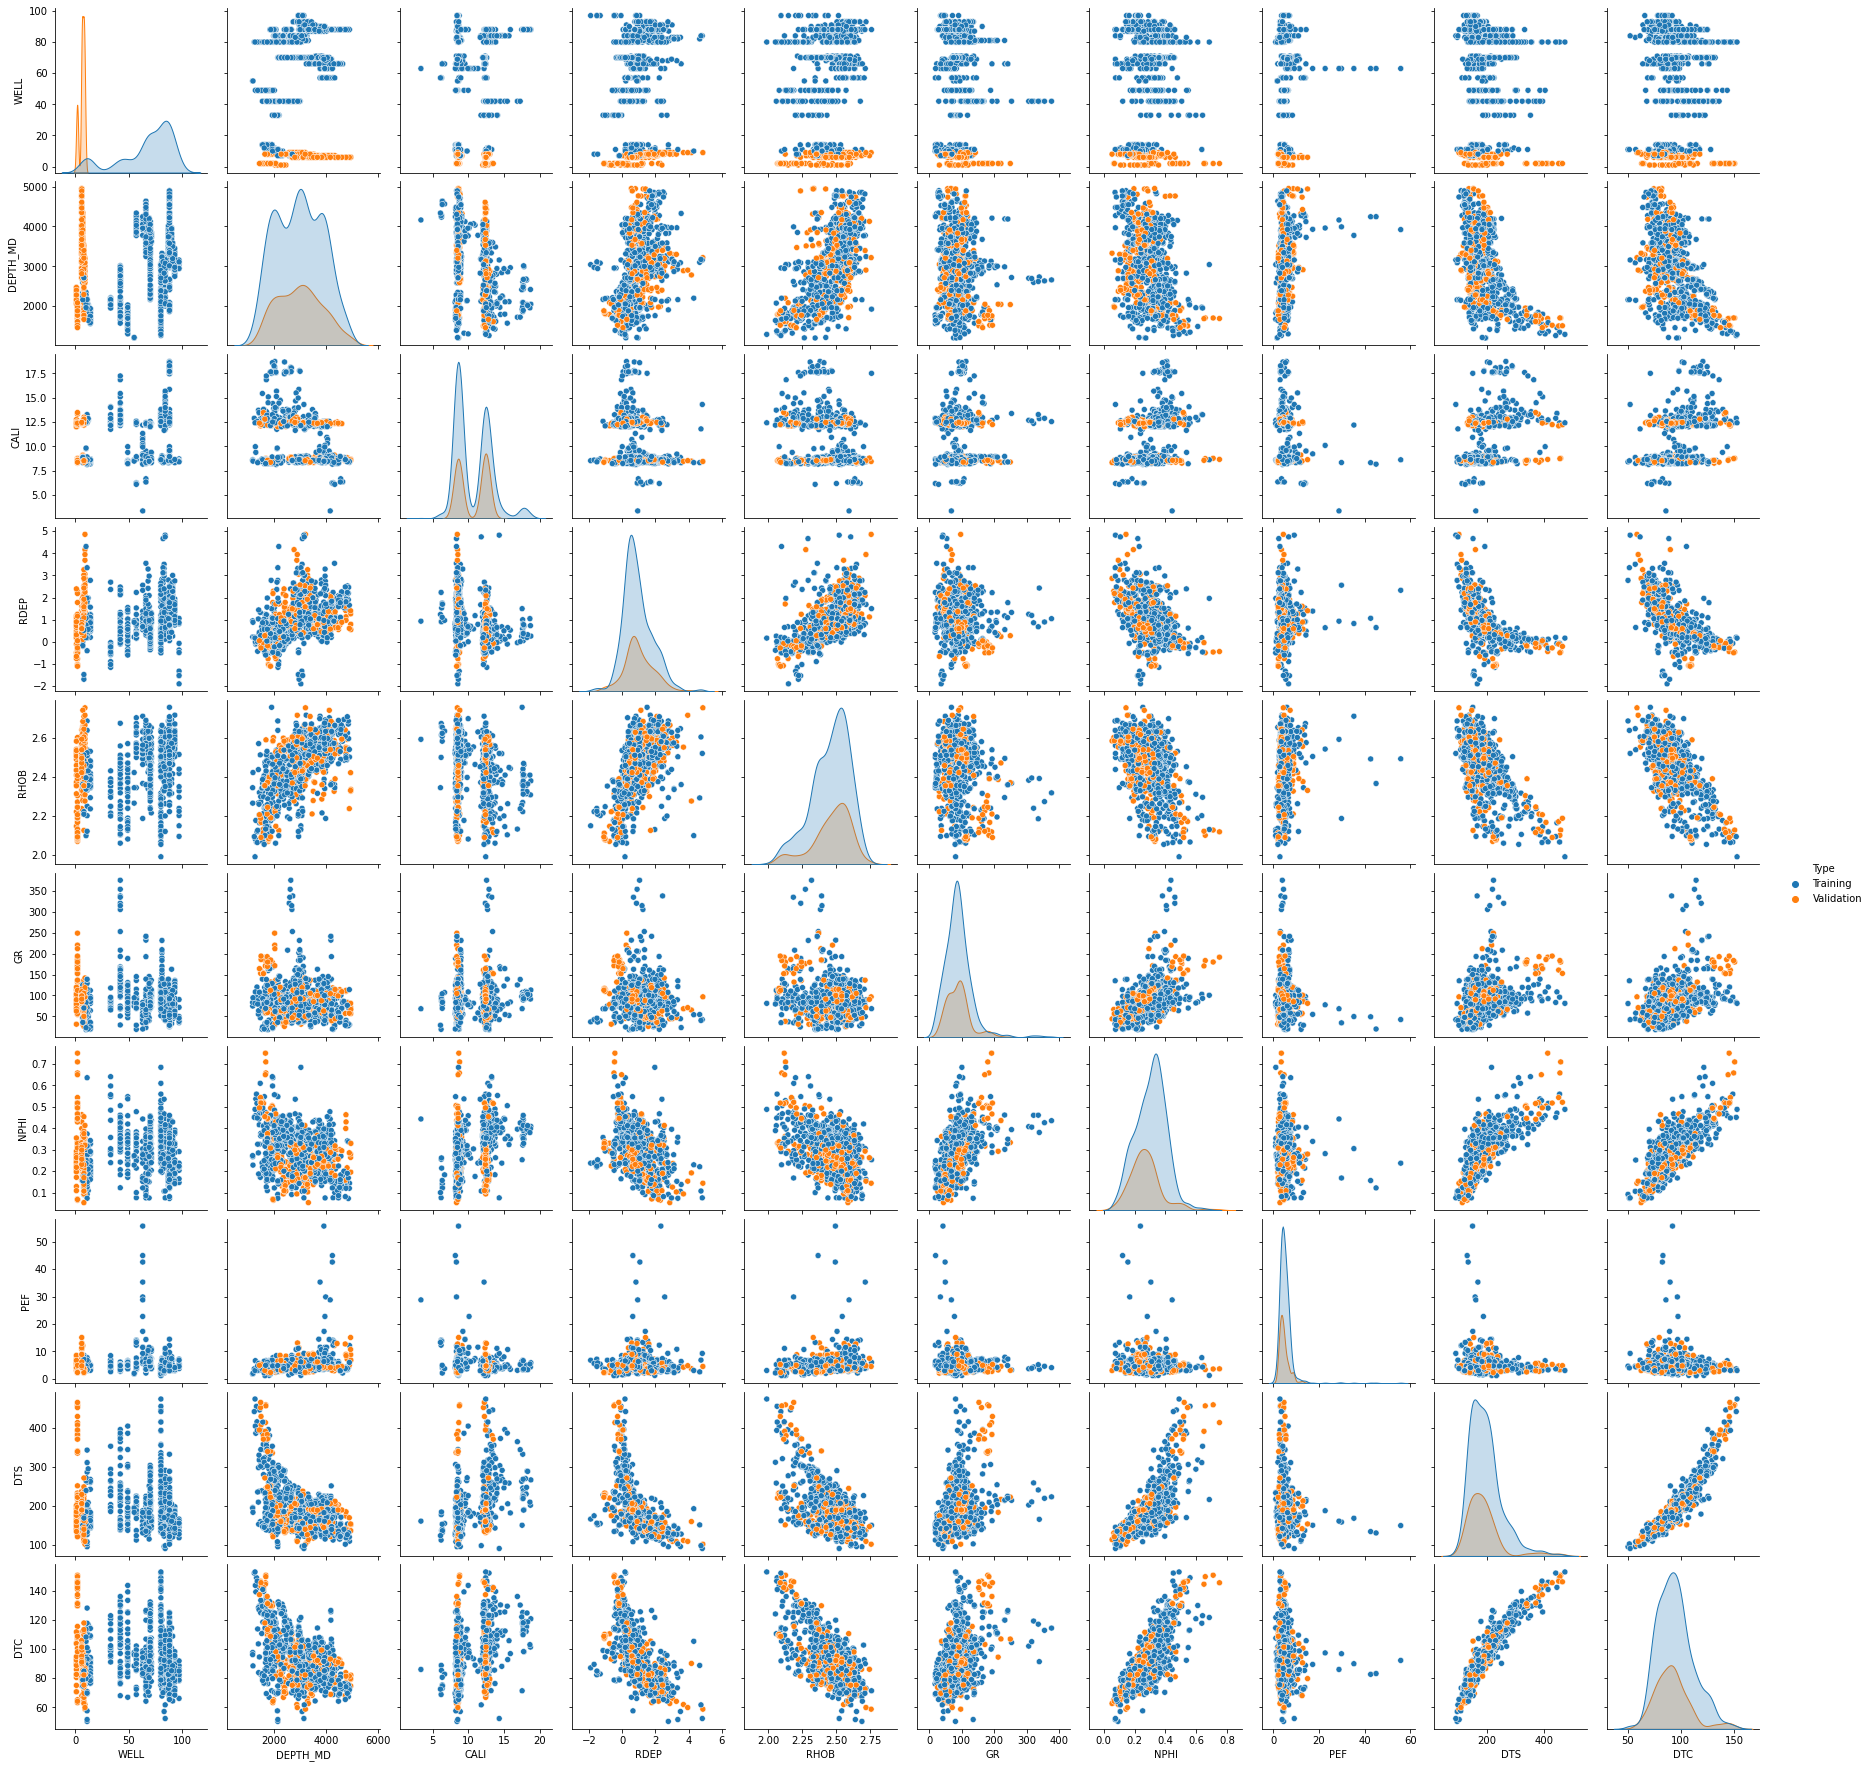

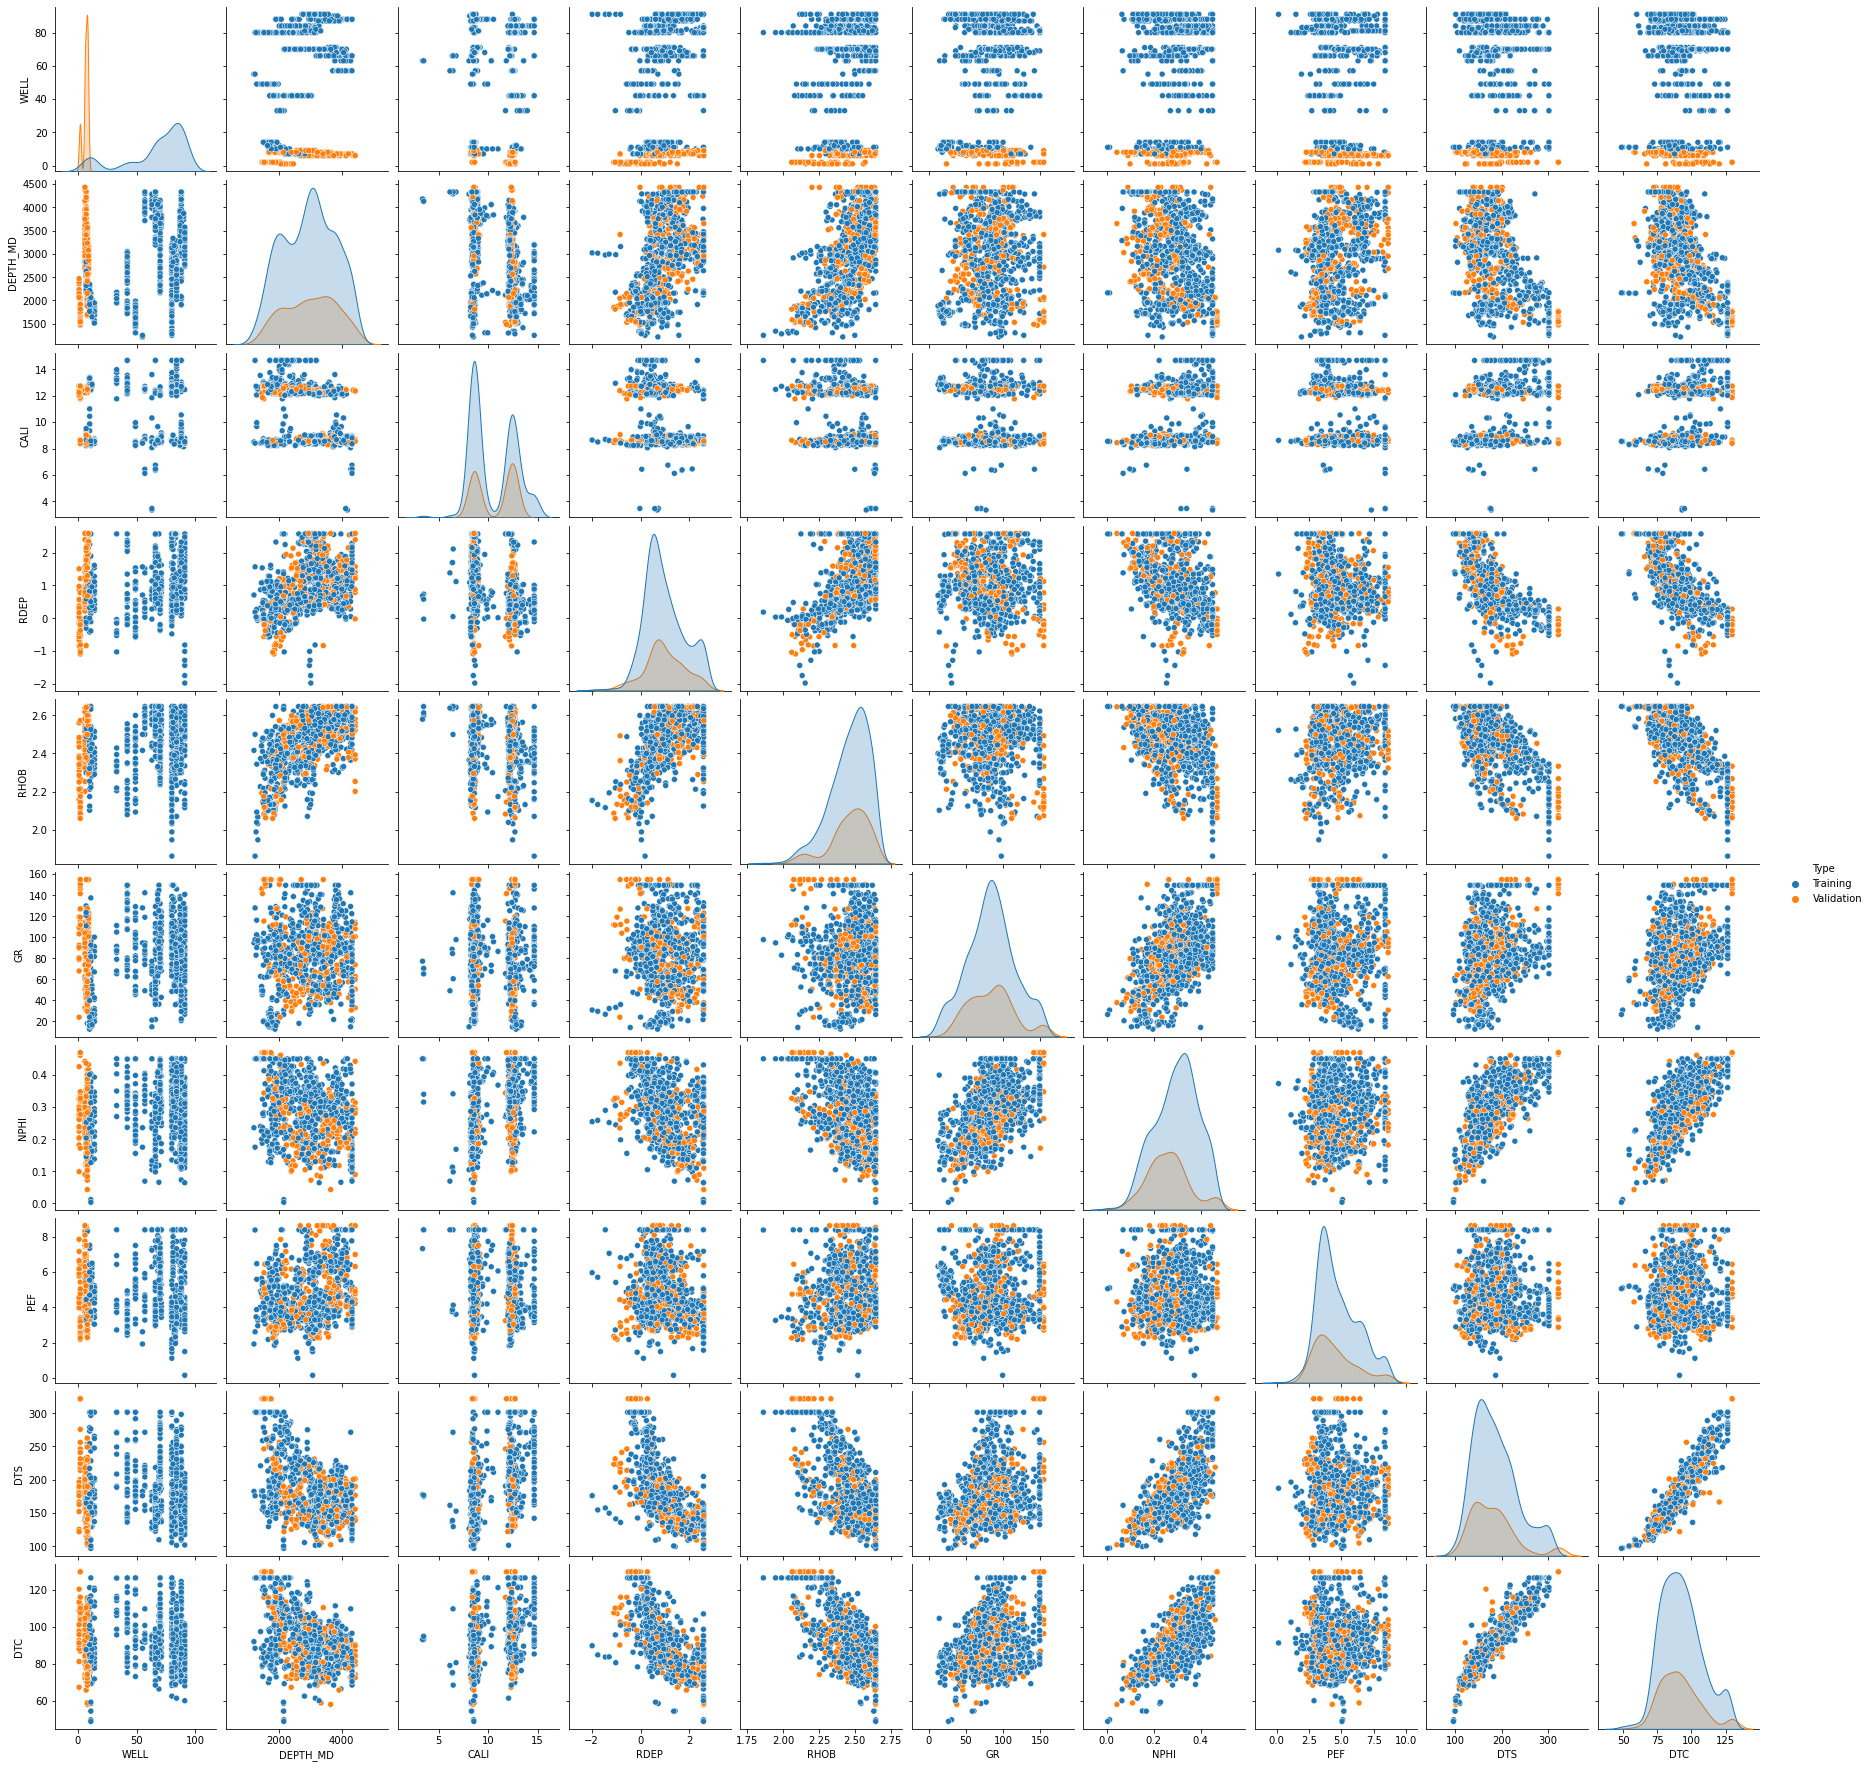

In [5]:
# Load the training data
train_data = pd.read_csv('../../../labs/data/train.csv', sep=';')
train_data['WELL'] = train_data['WELL'].astype('category').cat.codes

# Load the validing data
valid_data = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')
valid_data['WELL'] = valid_data['WELL'].astype('category').cat.codes

train_data = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()
valid_data = valid_data[~np.isnan(valid_data.DTS.values)][['WELL', 'DEPTH_MD','CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()

train_data['RDEP']=np.log(train_data.RDEP.values)
valid_data['RDEP']=np.log(valid_data.RDEP.values)

train_data['Type'] = 'Training'
valid_data['Type'] = 'Validation'

sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

train_data = train_data.mask(train_data>train_data.quantile(0.95), train_data.quantile(0.95), axis=1)
valid_data = valid_data.mask(valid_data>valid_data.quantile(0.95), valid_data.quantile(0.95), axis=1)

sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

transform = sklearn.preprocessing.MinMaxScaler()
df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

transform = sklearn.preprocessing.MinMaxScaler()
df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

# Select input
X_train = train_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_train = train_data[['DTS', 'WELL']].copy()

X_valid = valid_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_valid = valid_data[['DTS', 'WELL']].copy()

# Numpy to PyTorch Dataset

## Shear Sonic Prediction Dataset

In [6]:
# Define Train Set
X_train = torch.from_numpy(X_train.to_numpy()).float().view(-1,X_train.shape[1])
y_train = torch.from_numpy(y_train.to_numpy()).float().view(-1,y_train.shape[1])
train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_valid = torch.from_numpy(X_valid.to_numpy()).float().view(-1,X_valid.shape[1])
y_valid = torch.from_numpy(y_valid.to_numpy()).float().view(-1,y_valid.shape[1])
valid_dataset = TensorDataset(X_valid, y_valid)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=X_valid.size(0), shuffle=False)

torch.save(train_loader, '../data/train_loader.pth')    
torch.save(valid_loader, '../data/valid_loader.pth')   

torch.save(train_dataset, '../data/train_dataset.pth')    
torch.save(valid_dataset, '../data/valid_dataset.pth')   

## Facies Prediction Dataset

In [38]:
traindata = pd.read_csv('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/train.csv', sep=';')
validdata = pd.read_csv('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/leaderboard_test_features.csv', sep=';')

traindata_logavailability = 100 - (traindata.isna().sum()/traindata.shape[0])[2:-2] * 100
validdata_logavailability = 100 - (validdata.isna().sum()/validdata.shape[0])[2:] * 100

trainwellnames = traindata['WELL'].unique()

def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug

def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

def add_suffix(elements, string):
    return [el + string for el in elements]

nlithofacies = 12
lithofacies_names = {
    30000: 'Sandstone',
    65030: 'SS/Shale',
    65000: 'Shale',
    80000: 'Dolomite',
    74000: 'Tuff',
    70000: 'Marl',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Coal', 
    99000: 'Limestone',
    90000: 'Anhydrite', 
    93000: 'Basement'
}
lithofacies_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}
lithofacies_colors =  {
    30000: 'y',
    65030: '#96c136',
    65000: 'g',
    80000: '#5f5f5f',
    74000: 'k',
    70000: 'r',
    70032: '#e5E5E5',
    88000: 'c',
    86000: 'b',
    99000: 'm',
    90000: '#fe9300',
    93000: '#895347'
}

trainlabels = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_names).value_counts()

traindata.select_dtypes(include=np.number)

welldata = traindata[traindata['WELL'] == trainwellnames[1]]

las = lasio.LASFile()
numerical_columns = traindata.select_dtypes(include=np.number).columns
for log in numerical_columns:
    las.add_curve(log, welldata[log].values)

numerical_columns = traindata.select_dtypes(include=np.number).columns

dropped_cols = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO']

traindata = traindata.drop(dropped_cols, axis=1)
validdata = validdata.drop(dropped_cols, axis=1)

trainwellcodes = dict(zip(traindata['WELL'].astype('category').cat.codes, traindata['WELL'] ) )
trainwellcodes1 = dict((v,k) for k,v in trainwellcodes.items())

traindata['GROUP'] = traindata['GROUP'].astype('category').cat.codes 
traindata['FORMATION'] = traindata['FORMATION'].astype('category').cat.codes
traindata['WELL'] = traindata['WELL'].astype('category').cat.codes

validdata['GROUP'] = validdata['GROUP'].astype('category').cat.codes 
validdata['FORMATION'] = validdata['FORMATION'].astype('category').cat.codes
validdata['WELL'] = validdata['WELL'].astype('category').cat.codes

traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'] = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_numbers)

# Impute missing values 
traindata = traindata.fillna(method='pad')
validdata = validdata.fillna(method='pad')

traindata = traindata.fillna(method='backfill')
validdata = validdata.fillna(method='backfill')

A=np.load('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/penalty_matrix.npy')

# Choose which features to augument 
aug_labels = list(traindata.columns)
aug_labels.remove('WELL')
aug_labels.remove('FORCE_2020_LITHOFACIES_LITHOLOGY')
aug_labels.remove('FORCE_2020_LITHOFACIES_CONFIDENCE')
aug_traindata = augment_features(traindata.loc[:, aug_labels].values, traindata['WELL'], traindata['DEPTH_MD'])
aug_validdata = augment_features(validdata.loc[:, aug_labels].values, validdata['WELL'], validdata['DEPTH_MD'])
aug_newlabels = add_suffix(aug_labels, '_AVE1') + add_suffix(aug_labels, '_AVE2') + add_suffix(aug_labels, '_AVE3') + add_suffix(aug_labels, '_DIFF')

aug_traindata = pd.DataFrame(aug_traindata, columns=aug_newlabels)
aug_validdata = pd.DataFrame(aug_traindata, columns=aug_newlabels)

random.seed(15)
validnwells = 10
validwellnames = random.sample(list(trainwellnames), validnwells)
validwelllabels = [trainwellcodes1[wellname] for wellname in validwellnames]
validnwellcodes = dict((v,k) for k,v in zip(validwellnames, validwelllabels))
validnwellcodes1 = dict((v,k) for k,v in validnwellcodes.items()) # swap keys and values

validdata = traindata[traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)
traindata = traindata[~traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)

# trainlitho = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY']
# traindata = traindata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)

train_facies_all = traindata[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()
train_facies_data = train_facies_all.drop(columns='FORCE_2020_LITHOFACIES_LITHOLOGY')
train_facies_label = train_facies_all['FORCE_2020_LITHOFACIES_LITHOLOGY']

valid_facies_all = validdata[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()
valid_facies_data = valid_facies_all.drop(columns='FORCE_2020_LITHOFACIES_LITHOLOGY')
valid_facies_label = valid_facies_all['FORCE_2020_LITHOFACIES_LITHOLOGY']

train_facies_dataset = TensorDataset(torch.from_numpy(train_facies_data.to_numpy()).float().view(-1,10), torch.from_numpy(train_facies_label.to_numpy()).float().view(-1,1))
valid_facies_dataset = TensorDataset(torch.from_numpy(valid_facies_data.to_numpy()).float().view(-1,10), torch.from_numpy(valid_facies_label.to_numpy()).float().view(-1,1))

torch.save(train_facies_dataset, '../data/train_facies_dataset.pt')    
torch.save(valid_facies_dataset, '../data/valid_facies_dataset.pt')   

# Statistical Information

In [7]:
# Wells in number
print('The number of original training well are {}.'.format(len(np.unique(pd.read_csv('../../../labs/data/train.csv', sep=';')['WELL'].values))))
print('The number of trainig wells are {}.'.format(len(np.unique(train_data['WELL'].values))))
print('The number of original validing well are {}.'.format(len(np.unique(pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')['WELL'].values))))
print('The number of validing wells are {}.'.format(len(np.unique(valid_data['WELL'].values))))

# Each corresponding well length
print("Each well contains: ")
for i in np.unique(train_data['WELL'].values):
    print(len(train_data[train_data['WELL']==i]))

The number of original training well are 98.
The number of trainig wells are 26.
The number of original validing well are 10.
The number of validing wells are 6.
Each well contains: 
3551
1186
3639
3210
1654
2979
2091
10030
4950
241
3956
2171
8678
2043
3569
13222
1828
12687
3389
2175
2196
8622
5079
15747
2115
10745


# Plotting

In [8]:
def plot_wirelines(data_plot):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=data_plot, color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax2.set_xlabel("Resistivity - Deep")
    ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([0.1, 1, 10, 100, 1000])
    ax2.semilogx()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax3.set_xlabel("Density")
    ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=data_plot, color = "purple", linewidth = 0.5)
    ax4.set_xlabel("Sonic - Compressional")
    ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=data_plot, color = "blue", linewidth = 0.5)
    ax5.set_xlabel('Neutron')
    ax5.xaxis.label.set_color("blue")
    ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=data_plot, color = "black", linewidth = 0.5)
    ax6.set_xlabel("Caliper")
    ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("black")
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_edgecolor("black")
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

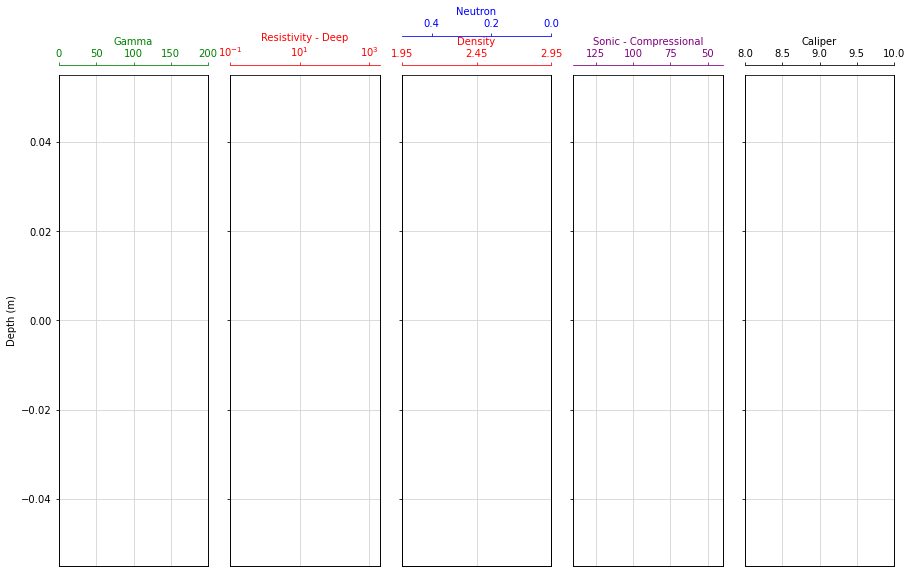

In [9]:
data_plot = train_data[train_data.WELL==55]#np.unique(train_data.WELL.values)[0]]
plot_wirelines(data_plot)

In [10]:
# Sanity check on each well length
print("Each well contains: ")
for i in np.unique(valid_data['WELL'].values):
    print(len(valid_data[valid_data['WELL']==i]))

Each well contains: 
2971
4063
11990
6194
13092
4262


# Wireline Segmentation/Splitting

In [11]:
# Naive way to segment the wireline data based on specific sequence length
seq_len = 512
df_train = train_data[train_data['WELL']==7][:seq_len]
for i in np.unique(train_data.WELL.values):
    sz = len(train_data[train_data['WELL']==i])//seq_len
    for j in range(sz):
        df_train_seq = train_data[train_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_train = df_train.append(df_train_seq, ignore_index=True)
    
    df_train = df_train.append(train_data[train_data['WELL']==i][-seq_len:], ignore_index=True)

df_valid = valid_data[valid_data['WELL']==1][:seq_len]
for i in np.unique(valid_data.WELL.values):
    sz = len(valid_data[valid_data['WELL']==i])//seq_len
    for j in range(sz):
        df_valid_seq = valid_data[valid_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_valid = df_valid.append(df_valid_seq, ignore_index=True)
    
    df_valid = df_valid.append(valid_data[valid_data['WELL']==i][-seq_len:], ignore_index=True)

In [12]:
# Removing less than sequence length well
for i in np.unique(train_data.WELL.values):
    if len(df_train[df_train.WELL==i])%seq_len!=0:
        print(i, len(train_data[train_data.WELL==55]))
        df_train = df_train.drop(df_train[df_train.WELL==i].index)

0.5714285714285714 0


In [13]:
df_train

WELL  DEPTH_MD      CALI      RDEP      RHOB        GR      NPHI  \
0        0.0  0.299840  0.515219  0.476766  0.696092  0.451378  1.000000   
1        0.0  0.299888  0.544348  0.477564  0.818459  0.416452  0.813712   
2        0.0  0.299937  0.561165  0.478175  0.746801  0.420450  0.640294   
3        0.0  0.299986  0.578645  0.479018  0.744049  0.428531  0.595095   
4        0.0  0.300034  0.597734  0.470602  0.737936  0.419202  0.647495   
...      ...       ...       ...       ...       ...       ...       ...   
136940   1.0  0.626301  0.448863  0.410940  0.743132  0.169310  0.364022   
136941   1.0  0.626349  0.449502  0.416652  0.773608  0.180976  0.384260   
136942   1.0  0.626398  0.447849  0.426750  0.790761  0.208092  0.400385   
136943   1.0  0.626447  0.447023  0.431832  0.771728  0.241781  0.388483   
136944   1.0  0.626495  0.449660  0.429146  0.752750  0.220842  0.409587   

             PEF       DTS       DTC      Type  
0       1.000000  0.348712  0.446837  Training  
1       0.914829  0.342554  0.433241  Training  
2       0.779658  0.337328  0.421899  Training  
3       0.845586  0.335467  0.419426  Training  
4       0.937795  0.336118  0.427114  Training  
...          ...       ...       ...       ...  
136940  0.785039  0.206627  0.701992  Training  
136941  0.831382  0.206642  0.707228  Training  
136942  0.852627  0.206642  0.707931  Training  
136943  0.866870  0.206603  0.700585  Training  
136944  0.865509  0.206318  0.664576  Training  

[136704 rows x 11 columns]

# Wrapping into PyTorch Dataloader

In [19]:
# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        data = self.data.drop(columns=['DTS','Type']).values[idx*self.seq_len:(idx+1)*self.seq_len]
        label = self.data['DTS'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

In [20]:
# Dataset
train_dataset = WirelineDataset(df_train, 512)
valid_dataset = WirelineDataset(df_valid, 512)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

# Save
torch.save(train_loader, '../data/train_loader.pth')    
torch.save(valid_loader, '../data/valid_loader.pth')   

torch.save(train_dataset, '../data/train_dataset.pth')    
torch.save(valid_dataset, '../data/valid_dataset.pth')   

In [21]:
# Sanity checks
for i in range(len(DataLoader(valid_dataset, shuffle=True))):
    wells = valid_dataset[i]
    print(wells['well'], wells['data'].shape, wells['label'].shape)

for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['data'].size(), sample_batched['label'].size())

1.0 (512, 9) (512, 1)
0.0 (512, 9) (512, 1)
0.0 (512, 9) (512, 1)
0.0 (512, 9) (512, 1)
0.0 (512, 9) (512, 1)
0.0 (512, 9) (512, 1)
0.0 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.125 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.625 (512, 9) (512, 1)
0.75 (512, 9) (512, 1)
0.75 (512, 9) (512, 1)
0.75 (512, 9) (512, 1)
0.75 (512